# HfModel Example

You can install torchkeras using pip:
`pip install torchkeras`

Here is the mnist example using torchkeras.HfModel. 


In [1]:
import sys 
sys.path.append("..")

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchkeras import HfModel 


### 1, prepare data 

In [3]:
import torchvision 
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
ds_train = torchvision.datasets.MNIST(root="mnist/",train=True,download=True,transform=transform)
ds_train = torch.utils.data.Subset(ds_train,indices=range(0,len(ds_train),30))

ds_val = torchvision.datasets.MNIST(root="mnist/",train=False,download=True,transform=transform)
ds_val = torch.utils.data.Subset(ds_val,indices=range(0,len(ds_val),30))

dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)


In [4]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([128, 1, 28, 28])
torch.Size([128])


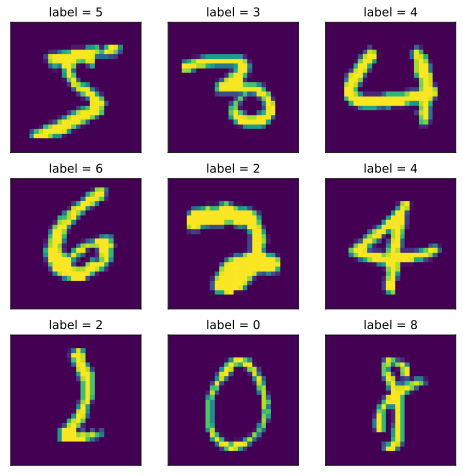

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()


### 2, create the  model

In [6]:
def create_net():
    net = nn.Sequential()
    net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
    net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
    net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
    net.add_module("dropout",nn.Dropout2d(p = 0.1))
    net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
    net.add_module("flatten",nn.Flatten())
    net.add_module("linear1",nn.Linear(64,32))
    net.add_module("relu",nn.ReLU())
    net.add_module("linear2",nn.Linear(32,10))
    return net

class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        



### 3, train the  model

In [7]:
net = create_net()
loss_fn = nn.CrossEntropyLoss()
metrics_dict = {"acc":Accuracy()}

model = HfModel(net,loss_fn,metrics_dict)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25000
  Number of trainable parameters = 53994


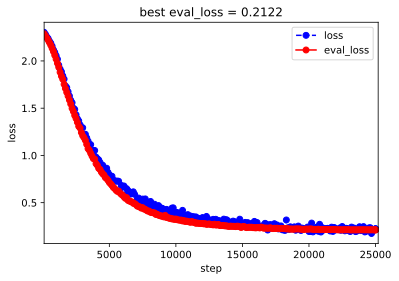

Step,Training Loss,Validation Loss,Acc
100,2.302500,2.287413,0.086826
200,2.281500,2.264840,0.251497
300,2.255400,2.243714,0.356287
400,2.237700,2.220091,0.449102
500,2.209100,2.194889,0.317365
600,2.188100,2.166768,0.437126
700,2.156500,2.133761,0.329341
800,2.117300,2.098864,0.416168
900,2.090300,2.059627,0.404192
1000,2.056000,2.019147,0.467066


***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
Saving model checkpoint to output_dir/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
***** Running Evaluation *****
  Num examples = 334
  Batch size = 8
Saving model checkpoint to output_dir/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 334
  Batch siz

In [8]:
%matplotlib inline 
model.fit(train_data=dl_train,
          val_data=dl_val,
          epochs=100,
          logging_steps=100,
          monitor='eval_loss',
          mode='min',
          patience=20,
          plot=True
         )


***** Running Evaluation *****
  Num examples = 334
  Batch size = 8


{'eval_loss': 0.21238884329795837,
 'eval_acc': 0.9371257424354553,
 'eval_runtime': 0.1003,
 'eval_samples_per_second': 3329.343,
 'eval_steps_per_second': 418.66,
 'epoch': 100.0}

### 4, evaluate the model

In [10]:
model.evaluate(dl_val)


***** Running Evaluation *****
  Num examples = 334
  Batch size = 8


{'eval_loss': 0.21238884329795837,
 'eval_acc': 0.9371257424354553,
 'eval_runtime': 0.1472,
 'eval_samples_per_second': 2268.792,
 'eval_steps_per_second': 285.297,
 'epoch': 100.0}

### 5, use the model

y_pred =  3
y_prob =  0.9523102641105652


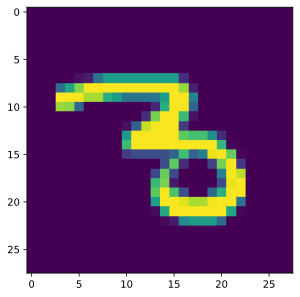

In [11]:
net = model.net
net.eval();

device = torch.device('cpu')
img,label = ds_train[1]
tensor = img.to(device)

y_pred = torch.argmax(net(tensor[None,...])) 
y_prob = torch.softmax(net(tensor[None,...]),dim=-1).max() 

img = img.permute(1,2,0)
plt.imshow(img)
print('y_pred = ', y_pred.item())
print('y_prob = ', y_prob.item())


### 6, save the model

In [13]:
#  used the saved model parameters 

torch.save(model.net.state_dict(),'checkpoint.pt')